In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install tensorflow tensorflow_hub tensorflow-addons scikit-learn


ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

data_dir = "/content/drive/MyDrive/BUIS dataset/archive (6)/Dataset_BUSI_with_GT"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")


In [5]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

VAL_SPLIT = 0.2

TEST_SPLIT = 0.2

SEED = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    validation_split=VAL_SPLIT + TEST_SPLIT,
    subset="training",
    seed=SEED
)

# Calculate the remaining data after training split for validation and test
remaining_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    validation_split=VAL_SPLIT + TEST_SPLIT, # Use a combined split for validation and test
    subset="validation", # Specify subset for the remaining data
    seed=SEED # Use the same seed as training
)

# Split the remaining data into validation and test sets
val_size = int((len(remaining_ds) * VAL_SPLIT) / (VAL_SPLIT + TEST_SPLIT))
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)


class_names = train_ds.class_names
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 1578 files belonging to 3 classes.
Using 947 files for training.
Found 1578 files belonging to 3 classes.
Using 631 files for validation.
Classes: ['benign', 'malignant', 'normal']


In [6]:
import os

# Verify if the data directory exists
print(f"Checking if data directory exists: {os.path.exists(data_dir)}")

# Verify if the train directory exists
print(f"Checking if train directory exists: {os.path.exists(train_dir)}")

# Verify if the valid directory exists
print(f"Checking if valid directory exists: {os.path.exists(valid_dir)}")

# List the contents of the data directory to help identify the correct path
if os.path.exists(data_dir):
    print(f"Contents of data directory {data_dir}: {os.listdir(data_dir)}")

Checking if data directory exists: True
Checking if train directory exists: False
Checking if valid directory exists: False
Contents of data directory /content/drive/MyDrive/BUIS dataset/archive (6)/Dataset_BUSI_with_GT: ['normal', 'benign', 'malignant']


In [7]:
import tensorflow_hub as hub
from tensorflow.keras import layers, models, Input
import tensorflow as tf

hub_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"

# Create a custom layer to wrap the Hub layer
class HubLayerWrapper(tf.keras.layers.Layer):
    def __init__(self, hub_url, trainable=False, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(hub_url, trainable=trainable)

    def call(self, inputs):
        return self.hub_layer(inputs)

# Use the Functional API to build the model
input_tensor = Input(shape=IMG_SIZE + (3,))
# Use the custom wrapper layer
base_model = HubLayerWrapper(hub_url, trainable=False)(input_tensor)
x = layers.Dropout(0.3)(base_model)
output_tensor = layers.Dense(len(class_names), activation="softmax")(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hub_layer_wrapper               │ (None, 1280)           │             0 │
│ (HubLayerWrapper)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,843 (15.01 KB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models, Input

hub_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"

# Create a custom layer to wrap the Hub layer
class HubLayerWrapper(tf.keras.layers.Layer):
    def __init__(self, hub_url, trainable=False, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(hub_url, trainable=trainable)

    def call(self, inputs):
        return self.hub_layer(inputs)

# Use the Functional API to build the model
input_tensor = Input(shape=IMG_SIZE + (3,))
# Use the custom wrapper layer
base_model = HubLayerWrapper(hub_url, trainable=False)(input_tensor)
x = layers.Dropout(0.3)(base_model)
output_tensor = layers.Dense(len(class_names), activation="softmax")(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hub_layer_wrapper_1             │ (None, 1280)           │             0 │
│ (HubLayerWrapper)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,843 (15.01 KB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystop_cb = EarlyStopping(monitor="val_loss",
                             patience=10,   # stop if no improvement for 10 epochs
                             restore_best_weights=True)

checkpoint_cb = ModelCheckpoint("efficientnetlite_best.h5",
                                save_best_only=True,
                                monitor="val_loss")

reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000000,     # huge number (effectively unlimited)
    initial_epoch=1,
    batch_size=32,
    callbacks=[earlystop_cb, checkpoint_cb, reduce_lr_cb],
    verbose=1
)

Epoch 2/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5326 - loss: 0.9569

30/30 ━━━━━━━━━━━━━━━━━━━━ 427s 14s/step - accuracy: 0.5331 - loss: 0.9560 - val_accuracy: 0.5781 - val_loss: 0.8842 - learning_rate: 1.0000e-04
Epoch 3/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5894 - loss: 0.8682

30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.5898 - loss: 0.8675 - val_accuracy: 0.5906 - val_loss: 0.8280 - learning_rate: 1.0000e-04
Epoch 4/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5955 - loss: 0.8328

30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5961 - loss: 0.8320 - val_accuracy: 0.6469 - val_loss: 0.7578 - learning_rate: 1.0000e-04
Epoch 5/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6398 - loss: 0.7723

30/30 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6401 - loss: 0.7718 - val_accuracy: 0.6281 - val_loss: 0.7394 - learning_rate: 1.0000e-04
Epoch 6/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6388 - loss: 0.7530

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6394 - loss: 0.7524 - val_accuracy: 0.6406 - val_loss: 0.7242 - learning_rate: 1.0000e-04
Epoch 7/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6624 - loss: 0.7205

30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6628 - loss: 0.7203 - val_accuracy: 0.7531 - val_loss: 0.6512 - learning_rate: 1.0000e-04
Epoch 8/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6821 - loss: 0.7030

30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6829 - loss: 0.7022 - val_accuracy: 0.7563 - val_loss: 0.6485 - learning_rate: 1.0000e-04
Epoch 9/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7049 - loss: 0.6967

30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7057 - loss: 0.6957 - val_accuracy: 0.7625 - val_loss: 0.6464 - learning_rate: 1.0000e-04
Epoch 10/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7422 - loss: 0.6548

30/30 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7427 - loss: 0.6540 - val_accuracy: 0.7781 - val_loss: 0.5792 - learning_rate: 1.0000e-04
Epoch 11/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7348 - loss: 0.6442 - val_accuracy: 0.7719 - val_loss: 0.5886 - learning_rate: 1.0000e-04
Epoch 12/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7581 - loss: 0.6179

30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7582 - loss: 0.6177 - val_accuracy: 0.7906 - val_loss: 0.5611 - learning_rate: 1.0000e-04
Epoch 13/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7513 - loss: 0.6238

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7521 - loss: 0.6223 - val_accuracy: 0.7875 - val_loss: 0.5478 - learning_rate: 1.0000e-04
Epoch 14/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7533 - loss: 0.5920

30/30 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.7539 - loss: 0.5914 - val_accuracy: 0.7844 - val_loss: 0.5439 - learning_rate: 1.0000e-04
Epoch 15/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7749 - loss: 0.5927 - val_accuracy: 0.7625 - val_loss: 0.5695 - learning_rate: 1.0000e-04
Epoch 16/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7616 - loss: 0.5709

30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7623 - loss: 0.5703 - val_accuracy: 0.7719 - val_loss: 0.5404 - learning_rate: 1.0000e-04
Epoch 17/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7751 - loss: 0.5502

30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7752 - loss: 0.5498 - val_accuracy: 0.7937 - val_loss: 0.5313 - learning_rate: 1.0000e-04
Epoch 18/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7740 - loss: 0.5574

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7742 - loss: 0.5568 - val_accuracy: 0.7875 - val_loss: 0.5258 - learning_rate: 1.0000e-04
Epoch 19/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7545 - loss: 0.5693

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7547 - loss: 0.5684 - val_accuracy: 0.8219 - val_loss: 0.4936 - learning_rate: 1.0000e-04
Epoch 20/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7649 - loss: 0.5607

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7658 - loss: 0.5593 - val_accuracy: 0.8156 - val_loss: 0.4867 - learning_rate: 1.0000e-04
Epoch 21/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7788 - loss: 0.5205 - val_accuracy: 0.7875 - val_loss: 0.5189 - learning_rate: 1.0000e-04
Epoch 22/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7641 - loss: 0.5337 - val_accuracy: 0.7844 - val_loss: 0.5248 - learning_rate: 1.0000e-04
Epoch 23/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7587 - loss: 0.5177 - val_accuracy: 0.7937 - val_loss: 0.5091 - learning_rate: 1.0000e-04
Epoch 24/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7982 - loss: 0.5059

30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7979 - loss: 0.5055 - val_accuracy: 0.8062 - val_loss: 0.4845 - learning_rate: 1.0000e-04
Epoch 25/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7906 - loss: 0.4946

30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7906 - loss: 0.4943 - val_accuracy: 0.8219 - val_loss: 0.4503 - learning_rate: 1.0000e-04
Epoch 26/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7907 - loss: 0.5021 - val_accuracy: 0.8156 - val_loss: 0.4824 - learning_rate: 1.0000e-04
Epoch 27/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7674 - loss: 0.5224 - val_accuracy: 0.8125 - val_loss: 0.4920 - learning_rate: 1.0000e-04
Epoch 28/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7736 - loss: 0.5079 - val_accuracy: 0.8313 - val_loss: 0.4679 - learning_rate: 1.0000e-04
Epoch 29/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7666 - loss: 0.4947 - val_accuracy: 0.8031 - val_loss: 0.4862 - learning_rate: 1.0000e-04
Epoch 30/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7837 - loss: 0.4808
Epoch 30: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 

30/30 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7695 - loss: 0.5076 - val_accuracy: 0.8375 - val_loss: 0.4415 - learning_rate: 5.0000e-05
Epoch 32/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7834 - loss: 0.5014 - val_accuracy: 0.8031 - val_loss: 0.4794 - learning_rate: 5.0000e-05
Epoch 33/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8081 - loss: 0.4763

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8081 - loss: 0.4761 - val_accuracy: 0.8406 - val_loss: 0.4395 - learning_rate: 5.0000e-05
Epoch 34/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7729 - loss: 0.4890

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7737 - loss: 0.4883 - val_accuracy: 0.8344 - val_loss: 0.4288 - learning_rate: 5.0000e-05
Epoch 35/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7895 - loss: 0.4773 - val_accuracy: 0.8375 - val_loss: 0.4463 - learning_rate: 5.0000e-05
Epoch 36/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7778 - loss: 0.5007 - val_accuracy: 0.8125 - val_loss: 0.4927 - learning_rate: 5.0000e-05
Epoch 37/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7690 - loss: 0.4927

30/30 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7698 - loss: 0.4917 - val_accuracy: 0.8469 - val_loss: 0.4224 - learning_rate: 5.0000e-05
Epoch 38/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7907 - loss: 0.4776

30/30 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7915 - loss: 0.4768 - val_accuracy: 0.8594 - val_loss: 0.4085 - learning_rate: 5.0000e-05
Epoch 39/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8025 - loss: 0.4602 - val_accuracy: 0.8375 - val_loss: 0.4424 - learning_rate: 5.0000e-05
Epoch 40/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8145 - loss: 0.4412 - val_accuracy: 0.8500 - val_loss: 0.4194 - learning_rate: 5.0000e-05
Epoch 41/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8153 - loss: 0.4407 - val_accuracy: 0.8375 - val_loss: 0.4214 - learning_rate: 5.0000e-05
Epoch 42/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8032 - loss: 0.4737 - val_accuracy: 0.8469 - val_loss: 0.4161 - learning_rate: 5.0000e-05
Epoch 43/1000000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7823 - loss: 0.4533
Epoch 43: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 

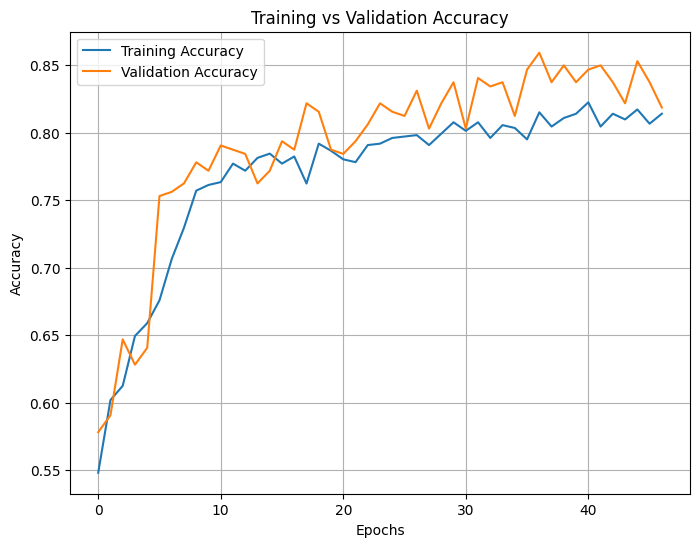

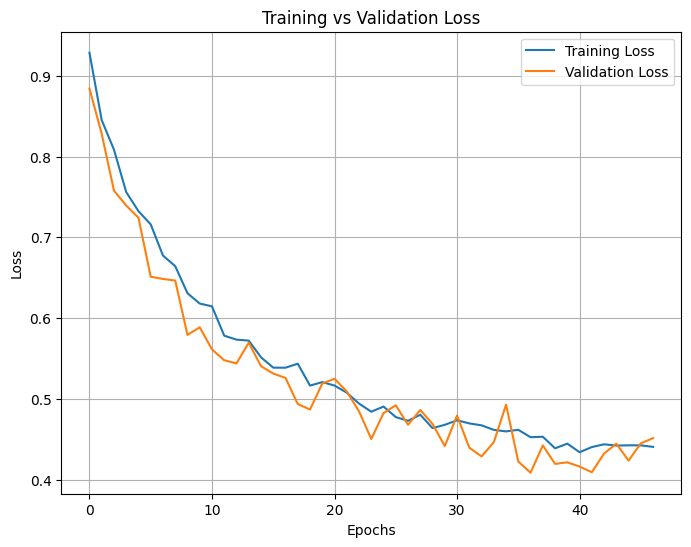

In [10]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()
model.save("/content/drive/MyDrive/my_model.h5")


In [11]:
test_loss, test_acc = model.evaluate(test_ds)
print("✅ Test Accuracy:", test_acc)


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7990 - loss: 0.4384
✅ Test Accuracy: 0.7942122220993042


In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Collect predictions
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classification Report:
              precision    recall  f1-score   support

      benign       0.79      0.97      0.87       173
   malignant       0.90      0.75      0.82        93
      normal       0.97      0.52      0.67        54

    accuracy                           0.83       320
   macro avg       0.88      0.75      0.79       320
weighted avg       0.85      0.83      0.82       320

Confusion Matrix:
[[168   5   0]
 [ 22  70   1]
 [ 23   3  28]]


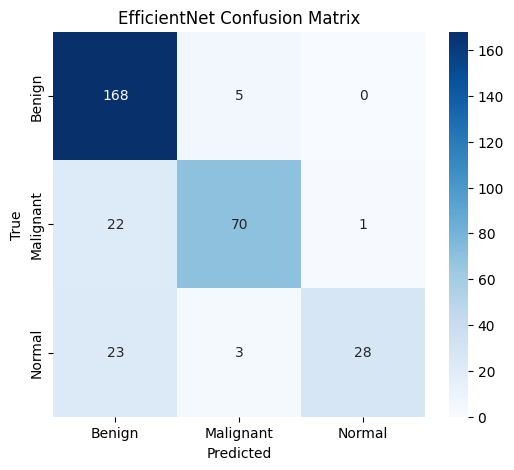

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malignant","Normal"],
            yticklabels=["Benign","Malignant","Normal"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EfficientNet Confusion Matrix")
plt.show()

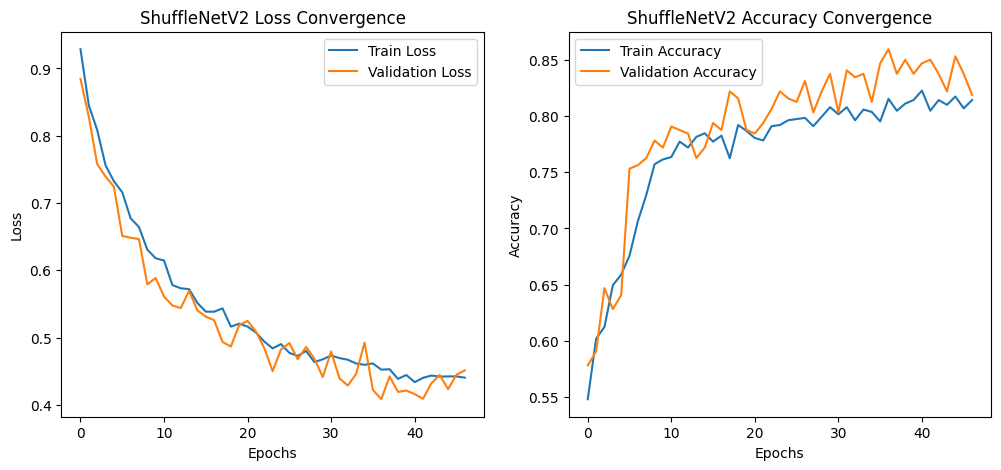

In [14]:
import matplotlib.pyplot as plt

# Assuming you have the 'history' object from model.fit()
# Example: history = model.fit(...)

plt.figure(figsize=(12,5))

# --- Loss Convergence ---
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ShuffleNetV2 Loss Convergence')
plt.legend()

# --- Accuracy Convergence ---
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ShuffleNetV2 Accuracy Convergence')
plt.legend()

plt.show()
